In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import gaussian_kde
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/scratch/mmosmond/projects/spacetrees-kelp/.venv/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


Directories

In [2]:
datadir = 'data/'
prefix = 'KL14_nereocystis/output_genTime10_customTimeBins/'
plotdir = 'plots/'

Sample locations

In [3]:
sample_locations = np.loadtxt(datadir + 'KL14_nereocystis/locations.txt')
n,d = sample_locations.shape

Ancestor locations

In [4]:
fns = [fn for fn in sorted(glob.iglob(datadir + prefix + 'JARUPZ0100000*.blup_locs'))]
locs = np.array([np.loadtxt(fn, delimiter=',') for fn in fns])
L = len(locs)
T = int(locs.shape[1]/n)
ancestor_times = locs[0,:T,1]
anc_locs = locs[:,:,-2:].reshape(L,n,T,d)
anc_locs.shape

(39, 772, 19, 2)

Plots

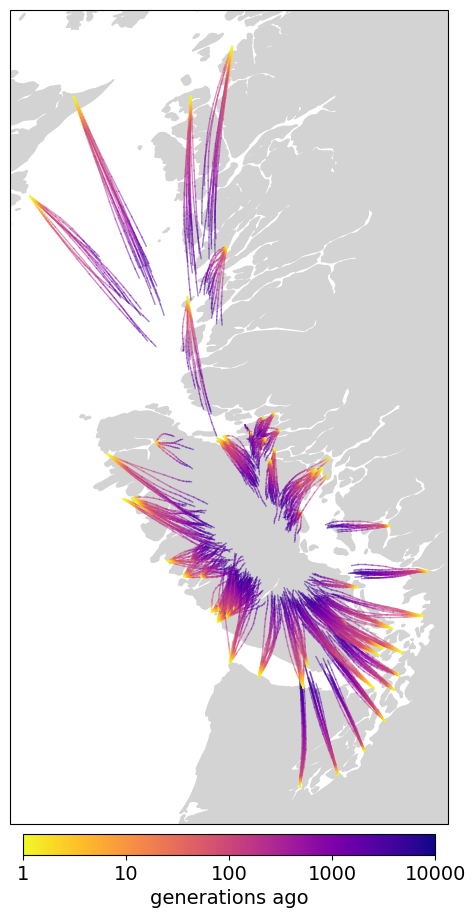

In [7]:
fig = plt.figure(figsize=(5, 10), dpi=100, edgecolor='k')
projection = ccrs.Robinson()
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
# ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in range(n): #for each sample

    # get mean ancestor location across loci at each time
    mean_locs = []
    mean_locs.append(sample_locations[sample]) #start with sample location
    for time_ix in range(T): 
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)
    
    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs) - 1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 1], mean_locs[i, 0]
        x1,y1 = mean_locs[i+1, 1], mean_locs[i+1, 0]
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic) #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.01, shrink=0.9)
# # cbar.set_ticks([i/4 for i in range(5)])
# # cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(5)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[-1]))
cbar.set_ticklabels(ts)
cbar.set_label(('generations ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
# plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

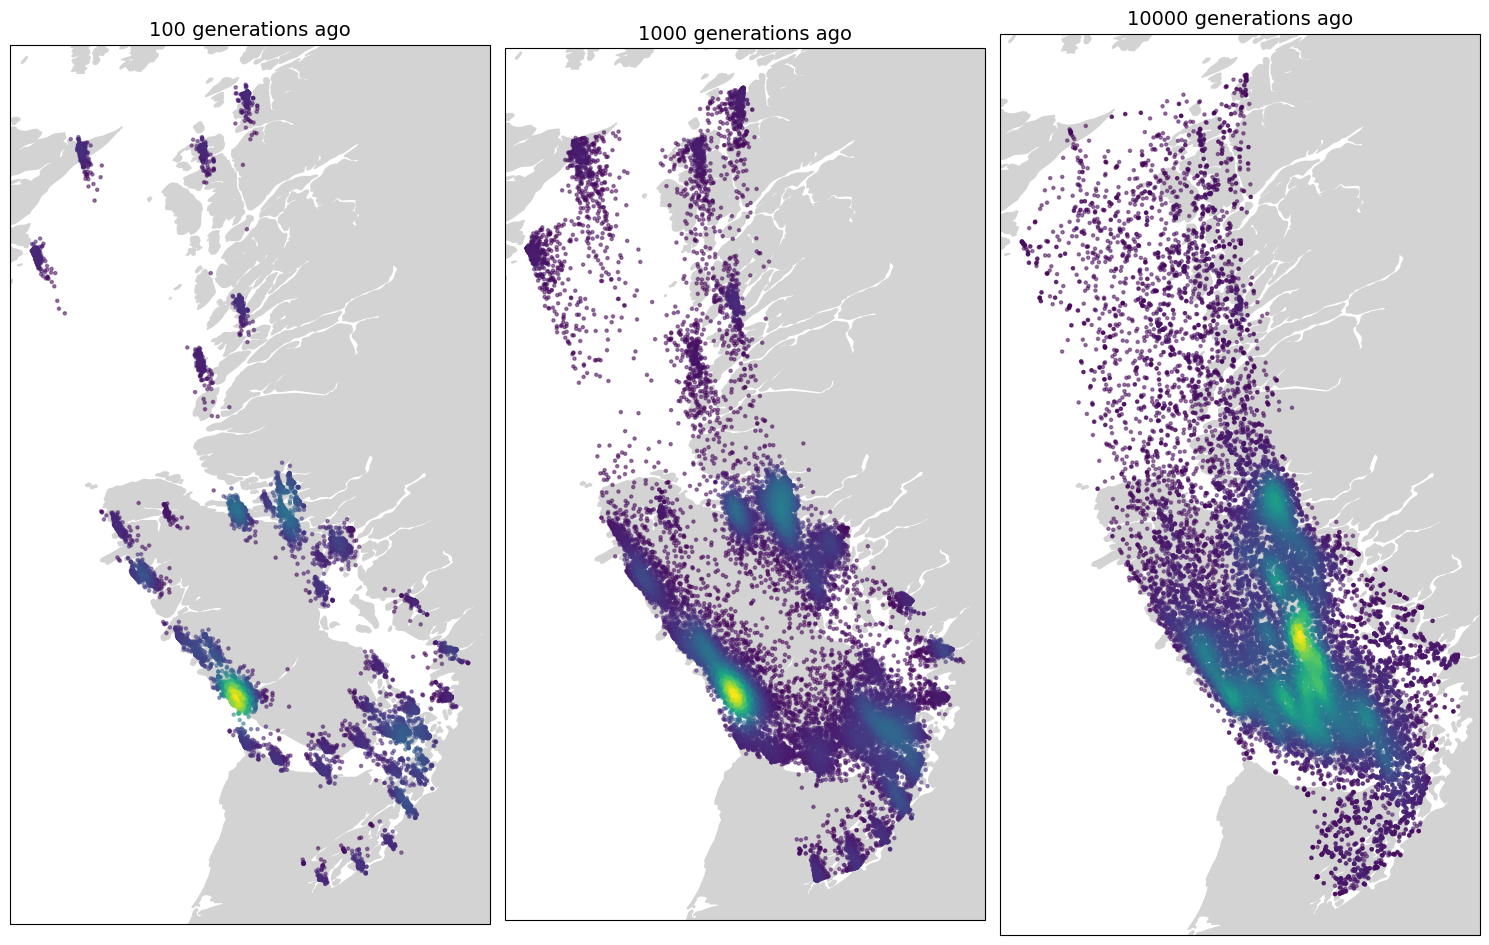

In [9]:
projection = ccrs.Robinson()
fig,axs = plt.subplots(1,3, subplot_kw={'projection': projection}, figsize=(15,10))
data_crs = ccrs.PlateCarree() #data supplied in lat/long

axs = axs.flatten()

for i,time_ix in enumerate([0,9,-1]):

    # ax = axs[i] = plt.axes(projection=projection)
    # axs[i].set_global()
    axs[i].add_feature(cfeature.LAND, color='lightgray')
    
    # all ancestors at given time
    all_locs = []
    for sample in range(n):
        locs = anc_locs[:, sample, time_ix]
        all_locs.append(locs)
    all_locs = np.vstack(all_locs)
    
    # estimate density
    xy = np.vstack([all_locs[:, 1], all_locs[:, 0]])
    kde = gaussian_kde(xy, bw_method=0.1) 
    z = kde(xy)

    # plot density
    sc = axs[i].scatter(all_locs[:, 1], all_locs[:, 0], c=z, s=5, marker='o', cmap='viridis', alpha=0.5, zorder=0, transform=data_crs)

    # color bar
    # cbar = plt.colorbar(sc, orientation='vertical', pad=0.01, shrink=0.75, ax=axs[i])

    # # text
    axs[i].text(0.5, 1.01, '%d generations ago' % int(ancestor_times[time_ix]), ha='center', fontsize=14, transform=axs[i].transAxes)

plt.tight_layout()
# plt.savefig(plotdir + 'wohns_4c.png')
plt.show()

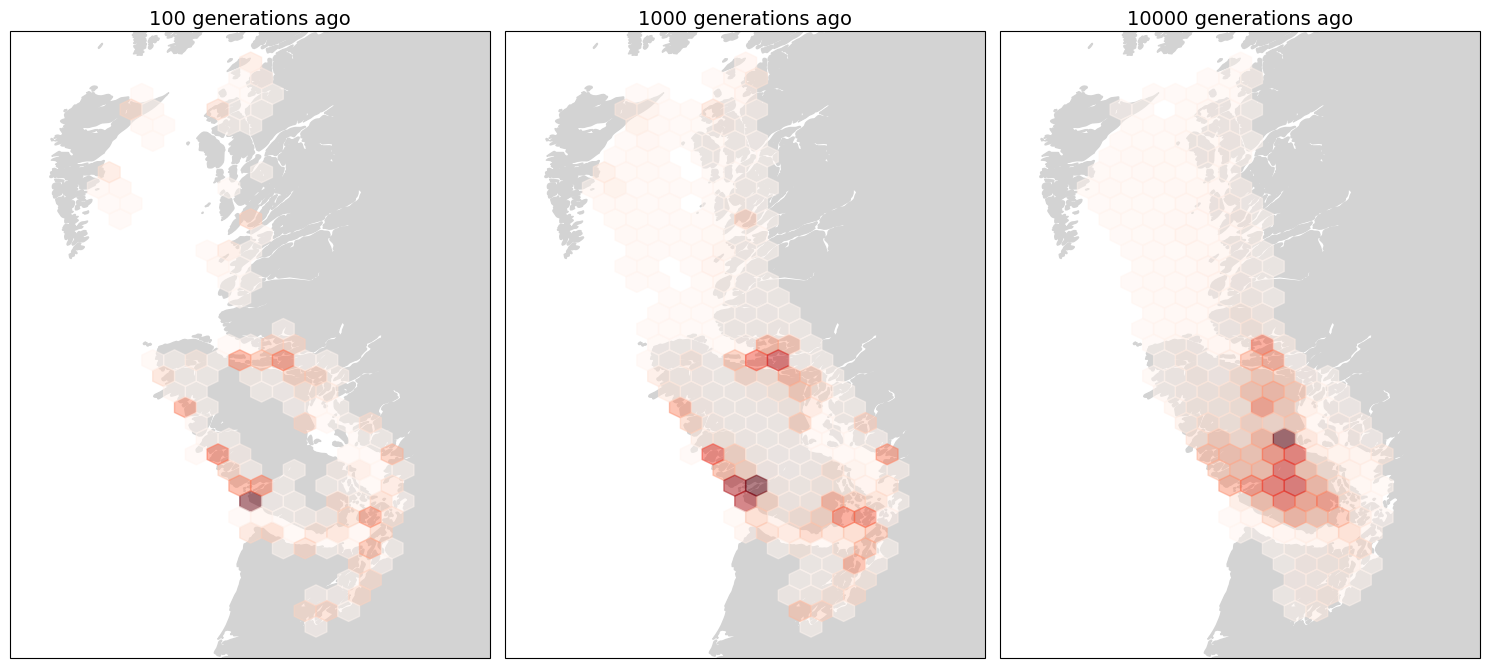

In [10]:
projection = ccrs.Robinson()
data_crs = ccrs.PlateCarree() #data supplied in lat/long
xlims = np.array([min(sample_locations[:,1])+5,max(sample_locations[:,1])-5])
ylims = np.array([min(sample_locations[:,0])-0.5,max(sample_locations[:,0])+0.5])
cmap = plt.get_cmap("Reds")

fig, axs = plt.subplots(1,3, figsize=(15,10), subplot_kw={'projection': projection})
axs = axs.flatten()

for i,time_ix in enumerate([0,9,-1]):

    axs[i].add_feature(cfeature.LAND, color='lightgray')

    # locations of all ancestors of all samples at this time
    all_locs = []
    for sample in range(n):
        all_locs.append(anc_locs[:, sample, time_ix])
    all_locs = np.vstack(all_locs) 

    # histogram
    binlims = axs[i].projection.transform_points(data_crs, xlims, ylims) 
    # ax.hexbin(x=all_locs[:,0], y=all_locs[:,1], transform=data_crs, cmap=cmap, gridsize=[30,10], alpha=0.5, extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]])
    axs[i].hexbin(x=all_locs[:,1], y=all_locs[:,0], transform=data_crs, cmap=cmap, gridsize=[20,20], extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]], alpha=0.5, mincnt=1)

    axs[i].set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], crs=data_crs)

    text = '%d generations ago' %int(ancestor_times[time_ix])
    axs[i].text(0.5,1.01,text,transform = axs[i].transAxes, ha='center', fontsize=14)

plt.tight_layout()
# plt.savefig(plotdir + 'grundler_4.png')
plt.show()

In [81]:
def polar_plot(bearings, ax=None, n=36, color='k', windrose_alpha=0.5):

    bins = np.arange(n + 1) * 360 / n
    width =  2 * np.pi / n

    frequencies, division = np.histogram(bearings, bins=bins, density=True)
    division = division[:-1]
    xs = division * np.pi / 180
        
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(polar=True)
        
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    ax.patch.set_alpha(windrose_alpha)
        
    bars = ax.bar(xs, frequencies, width=width, align='center', zorder=2, edgecolor='k', linewidth=0.5, alpha=0.7, color=color)
#     sns.kdeplot(x=bearings* np.pi / 180, ax=ax, fill=True, color=color, bw_adjust=0.5)
#     ax.set_ylabel(None)

    # ax.set_yticklabels(labels=[])
    # ax.set_xticklabels(labels=[])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_rticks([])
    
def windrose(groups, extent=None, time_ix=-1, filename=None, figsize=(5,15), windrose_size=0.5, windrose_alpha=0.5):
    
    # set up plot
    fig = plt.figure(figsize=figsize)
    projection = ccrs.PlateCarree()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    geodetic = ccrs.Geodetic() #for great circles
    # projection._threshold = projection._threshold/100.  #set finer threshold for smoother great circle lines
    ax = plt.axes(projection=projection)

    for group in groups:
    
        # get ancestor locations
        all_locs = []
        for sample in group:
            locs = anc_locs[:, sample, time_ix]
            all_locs.append(locs)
        all_locs = np.vstack(all_locs) 
    
        # plot the displacement at each locus as great circle
        # for loc in all_locs:
        #     lons = np.vstack([sample_locations[sample,1],loc[1]])
        #     lats = np.vstack([sample_locations[sample,0],loc[0]])
        #     ax.plot(lons, lats, transform=geodetic, alpha=0.5, color=plt.cm.tab10(0))
    
        # windrose inset
        geodesic = pyproj.Geod(ellps='WGS84')
        L,d = all_locs.shape
        bearings = np.zeros(L)
        distances = np.zeros(L)
        for i,(lat,long) in enumerate(all_locs):
            az1,_,d = geodesic.inv(sample_locations[sample,1],sample_locations[sample,0], long, lat)
            if az1 < 0:
                az1 = 360 + az1
            bearings[i] = az1
            distances[i] = d
        inset_ax = inset_axes(ax, width=windrose_size, height=windrose_size,
                              bbox_to_anchor=(sample_locations[sample,1],sample_locations[sample,0]), bbox_transform=ax.transData, 
                               loc='center', axes_class=matplotlib.projections.get_projection_class('polar'))
        polar_plot(ax=inset_ax, bearings=bearings, color=plt.cm.tab10(0))

    ax.add_feature(cfeature.LAND, color='lightgray')
    if extent is not None:
        ax.set_extent(extent, crs=data_crs)
    
    # plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [27]:
metadata = []
with open(datadir + 'KL14_nereocystis/geographicCoords_KL14_nereocystis.txt') as f:
    next(f)
    for line in f:
        metadata.append(line.split())

In [28]:
pops, pop_ix = np.unique([i[1] for i in metadata], return_inverse=True)

In [29]:
groups = []
for i,pop in enumerate(pops):
    group = []
    for j in range(n):
        if pop_ix.repeat(2)[j]==i:
            group.append(j)
    groups.append(group)

In [87]:
xlims = np.array([min(sample_locations[:,1])-1,max(sample_locations[:,1])+1])
ylims = np.array([min(sample_locations[:,0])-1,max(sample_locations[:,0])+1])
extent = [xlims[0],xlims[1],ylims[0],ylims[1]] 

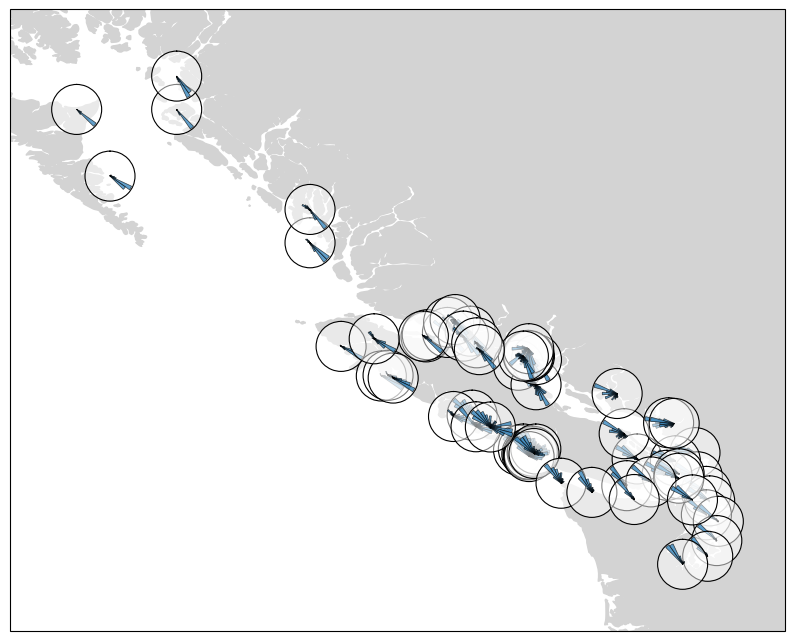

In [89]:
windrose(groups, figsize=(10,10), windrose_size=0.5, windrose_alpha=0.1, extent=extent)